Load & Overview

Number of categories: 21


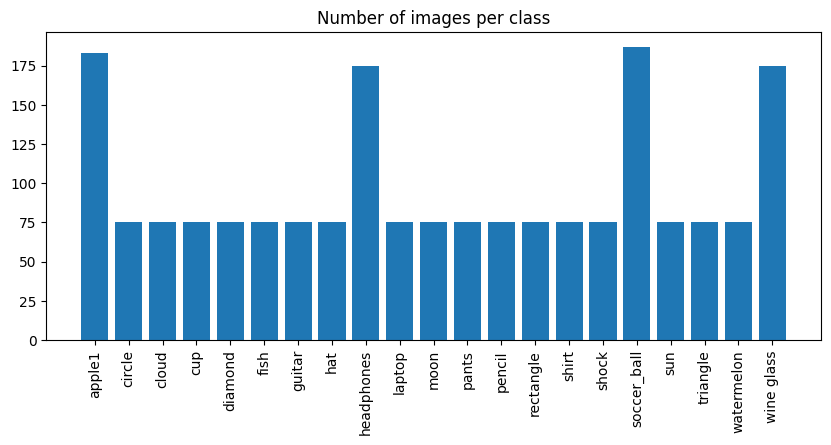

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
from collections import Counter

data_dir = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\dataset"

categories = os.listdir(data_dir)
print("Number of categories:", len(categories))

counts = {}
for c in categories:
    folder = os.path.join(data_dir, c)
    counts[c] = len(os.listdir(folder))

plt.figure(figsize=(10, 4))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=90)
plt.title("Number of images per class")
plt.show()


Visual Inspection (Hiểu trực quan dữ liệu): Xem ngẫu nhiên vài ảnh từ mỗi lớp để cảm nhận phong cách vẽ, độ phức tạp, độ nhiễu, v.v.

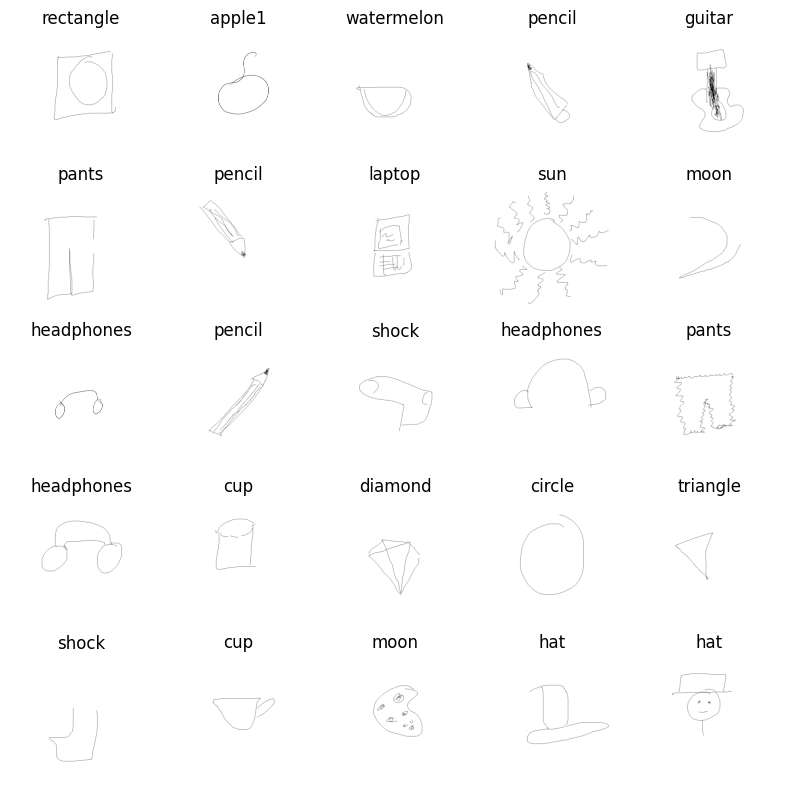

In [4]:
import random
fig, axes = plt.subplots(5, 5, figsize=(8, 8))
for ax in axes.flat:
    c = random.choice(categories)
    img_path = os.path.join(data_dir, c, random.choice(os.listdir(os.path.join(data_dir, c))))
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    ax.imshow(img, cmap='gray')
    ax.set_title(c)
    ax.axis('off')
plt.tight_layout()
plt.show()


Check image properties:

* Kích thước ảnh có đồng nhất không?

* Có ảnh nào bị hỏng không đọc được không?

In [5]:
sizes = []
for c in categories:
    folder = os.path.join(data_dir, c)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is None:
            print("Corrupted:", img_path)
            continue
        sizes.append(img.shape[:2])  # (height, width)
        
import pandas as pd
pd.Series(sizes).value_counts().head()


Corrupted: C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\dataset\sun\40.jpg
Corrupted: C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\dataset\sun\42.jpg


(563, 627)      1503
(2154, 1668)     420
(563, 653)        55
(980, 980)         2
(980, 1470)        2
Name: count, dtype: int64

Image Preprocessing

In [13]:
import cv2
import numpy as np
def preprocess_image(img_path, size=(64,64)):
    # Đọc ảnh grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)

    # Chuẩn hóa [0,1]
    img = img / 255.0

    # --- BƯỚC 1: Tăng độ tương phản / threshold ---
    img = (img < 0.8).astype(np.uint8) * 255  # nét vẽ rõ hơn

    # --- BƯỚC 2: Làm nét (tăng độ dày nét) ---
    kernel = np.ones((3,3), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)  # tăng nét lên 5 lần

    # Chuẩn hóa lại về [0,1]
    img = img / 255.0

    # Thêm trục kênh để phù hợp với CNN
    img = np.expand_dims(img, axis=-1)

    return img


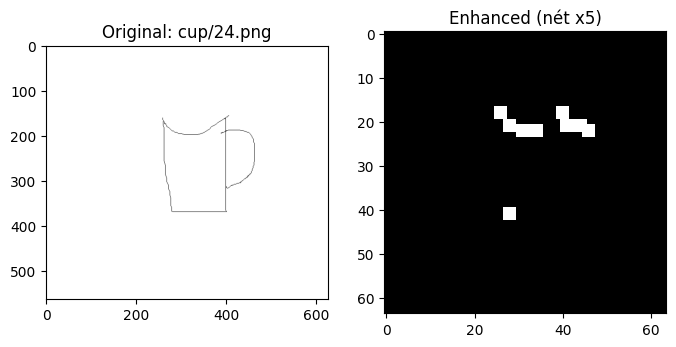

In [24]:
import matplotlib.pyplot as plt

data_dir = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\dataset"

# Lấy danh sách class
categories = os.listdir(data_dir)

# Chọn ngẫu nhiên 1 class
random_class = random.choice(categories)
folder = os.path.join(data_dir, random_class)

# Chọn ngẫu nhiên 1 ảnh trong class đó
img_name = random.choice(os.listdir(folder))
path = os.path.join(folder, img_name)

# Xử lý
original = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
processed = preprocess_image(path)

# Hiển thị
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(original, cmap='gray')
plt.title(f"Original: {random_class}/{img_name}")

plt.subplot(1,2,2)
plt.imshow(processed.squeeze(), cmap='gray')
plt.title("Enhanced (nét x5)")
plt.show()


Augmentation 

In [ ]:
import os
import json
import random
from PIL import Image, ImageDraw
from tqdm import tqdm

# --- 📂 THƯ MỤC CHỨA FILE .NDJSON ---
ndjson_dir = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\dataset"

# --- 📂 THƯ MỤC LƯU ẢNH ---
save_root = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\dataset_64x64"
os.makedirs(save_root, exist_ok=True)

# --- 🧩 SỐ LƯỢNG MẪU MỖI LỚP ---
num_samples = 500

# --- 📜 DUYỆT QUA CÁC FILE .NDJSON ---
for filename in os.listdir(ndjson_dir):
    if not filename.endswith(".ndjson"):
        continue

    cls = os.path.splitext(filename)[0]  # Tên lớp từ tên file
    print(f"\n🎨 Processing class: {cls}")
    
    # Tạo thư mục lưu ảnh cho class
    class_dir = os.path.join(save_root, cls)
    os.makedirs(class_dir, exist_ok=True)

    # Đọc toàn bộ dữ liệu từ file NDJSON
    file_path = os.path.join(ndjson_dir, filename)
    with open(file_path, 'r') as f:
        data_lines = f.readlines()

    valid_drawings = []

    # --- Lọc các mẫu hợp lệ ---
    for line in data_lines:
        data = json.loads(line)
        if not data.get("recognized", False):
            continue  # bỏ các mẫu chưa được nhận dạng
        if len(data["drawing"]) < 2:
            continue  # bỏ mẫu có ít hơn 2 nét vẽ
        valid_drawings.append(data["drawing"])

    print(f"✅ Found {len(valid_drawings)} valid drawings for '{cls}'")

    # --- Lấy ngẫu nhiên 250 mẫu ---
    samples = random.sample(valid_drawings, min(num_samples, len(valid_drawings)))

    # --- Vẽ và lưu ảnh ---
    for i, drawing in enumerate(tqdm(samples)):
        # Canvas trắng 256x256
        img = Image.new("L", (256, 256), 255)
        draw = ImageDraw.Draw(img)

        # Vẽ các stroke
        for stroke in drawing:
            points = list(zip(stroke[0], stroke[1]))
            draw.line(points, fill=0, width=5)  # nét vẽ dày

        # Resize xuống 64x64
        img = img.resize((64, 64))

        # Lưu file PNG
        save_path = os.path.join(class_dir, f"{i}.png")
        img.save(save_path)

    print(f"✅ Saved {len(samples)} images for '{cls}'")

print("\n🎯 Done! Dataset saved in folder:", save_root)



🎯 Done! Dataset saved in folder: C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\dataset_64x64


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)


Visualization for Preprocessing Results

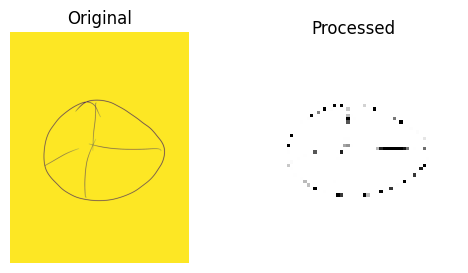

In [33]:
original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
processed = preprocess_image(img_path)

fig, ax = plt.subplots(1, 2, figsize=(6,3))
ax[0].imshow(original)
ax[0].set_title("Original")
ax[1].imshow(processed, cmap='gray')
ax[1].set_title("Processed")
for a in ax: a.axis('off')
plt.show()


Thống kê phân bố đặc trưng

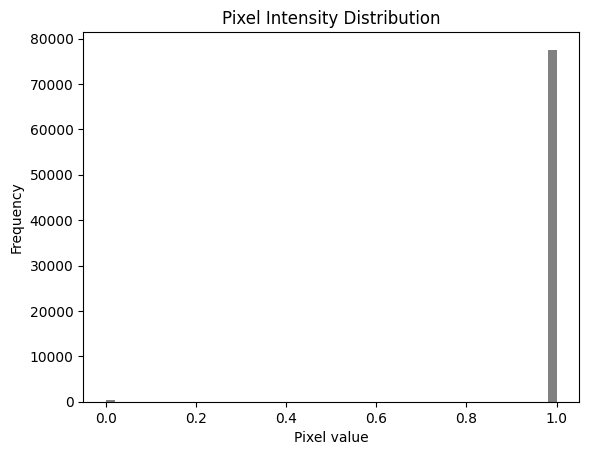

In [21]:
import numpy as np

all_pixels = []
for c in categories:
    folder = os.path.join(data_dir, c)
    for img_name in os.listdir(folder)[:50]:
        img_path = os.path.join(folder, img_name)
        img = preprocess_image(img_path)
        all_pixels.extend(img.flatten())

plt.hist(all_pixels, bins=50, color='gray')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()
